##### Load Hamiltonian

In [1]:
### Here we have the tapered Rabi-Hubbard Qubit Hamiltonian
import pickle
from pytket.utils.operators import QubitPauliOperator


L = 2 # two cavities
wc = 1 # cavity frequency
g = 0.1 * wc
J = 0.1 # hopping strength
delta = 10**-1 # detuning

filename = f'H_rh_qpo.pkl'
H_file = open(filename, 'rb')
H_load = pickle.load(H_file)
H_qpo = QubitPauliOperator.from_list(H_load)
print(H_qpo)

{(Iq[0], Iq[1], Iq[2], Xq[3], Iq[4]): 0.0125000000000000, (Iq[0], Iq[1], Xq[2], Xq[3], Iq[4]): 0.0176776695296637, (Iq[0], Iq[1], Yq[2], Yq[3], Iq[4]): 0.0176776695296637, (Iq[0], Iq[1], Zq[2], Xq[3], Iq[4]): 0.0125000000000000, (Iq[0], Zq[1], Iq[2], Xq[3], Zq[4]): -0.0125000000000000, (Iq[0], Zq[1], Xq[2], Xq[3], Zq[4]): 0.0176776695296637, (Iq[0], Zq[1], Yq[2], Yq[3], Zq[4]): 0.0176776695296637, (Iq[0], Zq[1], Zq[2], Xq[3], Zq[4]): -0.0125000000000000, (Xq[0], Iq[1], Iq[2], Xq[3], Iq[4]): 0.0176776695296637, (Xq[0], Iq[1], Xq[2], Xq[3], Iq[4]): 0.0250000000000000, (Xq[0], Iq[1], Yq[2], Yq[3], Iq[4]): 0.0250000000000000, (Xq[0], Iq[1], Zq[2], Xq[3], Iq[4]): 0.0176776695296637, (Xq[0], Zq[1], Iq[2], Xq[3], Zq[4]): 0.0176776695296637, (Xq[0], Zq[1], Xq[2], Xq[3], Zq[4]): -0.0250000000000000, (Xq[0], Zq[1], Yq[2], Yq[3], Zq[4]): -0.0250000000000000, (Xq[0], Zq[1], Zq[2], Xq[3], Zq[4]): 0.0176776695296637, (Yq[0], Iq[1], Iq[2], Yq[3], Iq[4]): 0.0176776695296637, (Yq[0], Iq[1], Xq[2], Yq[3

##### Load initial state

In [2]:

### We use mott insulator state as initial state. We load the tapered state as a numpy.ndarray.
filename = f'mott_state.pkl'
state_file = open(filename, 'rb')
state_load = pickle.load(state_file)
mott_sv = state_load['state_vec']
mott_qs = state_load['qubit_state']




##### Define the evolution time

In [3]:

import numpy as np

### Time grid
ddt = -1j * 0.05 # small parameter in Taylor expansion and truncation
Nt = 20 # no. of grid points
ti = 0.05/J
tf = 1/J
dt = (tf - ti)/ (Nt -1) # width of the time
tt = np.arange(ti, tf+dt,dt)
print(f'small param in Taylor series: {abs(ddt)} \ntime step width: {dt}, \ntime-axis grid points: {tt}')
iter0 = dt/abs(ddt)
print(f'no. of small-t-prop iterations to first time step: {iter0}')

small param in Taylor series: 0.05 
time step width: 0.5, 
time-axis grid points: [ 0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5  7.
  7.5  8.   8.5  9.   9.5 10. ]
no. of small-t-prop iterations to first time step: 10.0


#### Without using LCU... Only matrices and vector and expm.

In [4]:
from scipy.linalg import expm
from pandas import DataFrame

state0 = mott_sv
state0 = state0/np.sqrt(state0.T @ state0)

times = []
overlaps = []
sq_overlaps = []
rate_params = []
for t in tt:
    exp_iht = expm(-1j*t*H_qpo.to_sparse_matrix().todense())
    statef = exp_iht @ state0
    statef = statef / np.sqrt(statef.conj().T @ statef)
    # print(statef, state0)
    overlap = (state0.T @ statef).round(5)[0]
    sq_overlap = np.abs(overlap[0])**2
    times.append(t*J)
    overlaps.append(overlap.astype(complex))
    sq_overlaps.append(sq_overlap)
    rate_params.append(-0.5 * np.log2(sq_overlap))

exact_sv_data = DataFrame({'time': times,
                        'Overlap': overlaps,
                        'Sq_overlap': sq_overlaps,
                        'RateParam': rate_params})
print(exact_sv_data)

    time                Overlap  Sq_overlap  RateParam
0   0.05   [(0.46771-0.87145j)]    0.978178   0.015916
1   0.10   [(-0.52625-0.8031j)]    0.921909   0.058652
2   0.15  [(-0.91883+0.07074j)]    0.849253   0.117867
3   0.20  [(-0.36135+0.80011j)]    0.770750   0.187833
4   0.25   [(0.50471+0.65552j)]    0.684439   0.273503
5   0.30   [(0.75262-0.13667j)]    0.585116   0.386603
6   0.35   [(0.19421-0.66176j)]    0.475644   0.536023
7   0.40     [(-0.44683-0.41j)]    0.367757   0.721588
8   0.45  [(-0.48518+0.19475j)]    0.273327   0.935650
9   0.50  [(-0.01959+0.44413j)]    0.197635   1.169544
10  0.55   [(0.34001+0.15696j)]    0.140243   1.416998
11  0.60   [(0.21815-0.22664j)]    0.098955   1.668541
12  0.65  [(-0.13663-0.23064j)]    0.071863   1.899308
13  0.70   [(-0.2269+0.07458j)]    0.057046   2.065868
14  0.75   [(0.02546+0.22594j)]    0.051697   2.136886
15  0.80   [(0.22662+0.02893j)]    0.052194   2.129992
16  0.85   [(0.09552-0.21423j)]    0.055019   2.091969
17  0.90  

#### Taylor expand and truncate the propagator seed exp(-iHdt) 

In [5]:
### !!!!!This is going to be super slow. inquanto is much faster.!!!!
# from expand import ExpQubitOper

# ddt_ok = 0
# while ddt_ok == 0:
#     qubit_ihddt = ddt * H_qpo
#     # print(qubit_ihddt)
#     # qubit_ihddt_tapered.map(complex)
#     exp_ihddt_mat = expm(qubit_ihddt.to_sparse_matrix().todense()) #exact exp_ihdt in matrix form
#     # # print(qubit_ihddt_tapered.df().sort_values(by='Coefficient', key=abs, ascending=False))
#     exp_ihddt = ExpQubitOper(qubit_ihddt, k=8).taylor_expand()
#     # ddt_ok=1
#     exp_ihddt.compress(10**-8)
#     # prop_ddt = exp_ihddt.df().sort_values(by='Coefficient', key=abs, ascending=False)
#     # print(prop_ddt.Coefficient[0])
#     if max(np.abs(list(exp_ihddt._dict.values()))) < 1:
#         ddt_ok = 1
#     else:
#         print(f'Propagator coeff is greater than 1')
#         ddt = -1j * np.abs(ddt)/2

# print(f'ddt: {ddt}')
# # Product of 2 for loops should be equal to the no. of iterations to t1
# exp_ihdt5 = QubitPauliOperator({QubitPauliString():1})
# for i in range(5):
#     print(i)
#     exp_ihdt5 = exp_ihdt5 * exp_ihddt
#     exp_ihdt5.compress(10**-8)
    
# exp_ihdt = QubitPauliOperator({QubitPauliString():1})
# for i in range(int(dt/abs(ddt)/5)):
#     print(i)
#     exp_ihdt = exp_ihdt * exp_ihdt5
#     exp_ihdt.compress(10**-8)

filename = f'exp_ihdt_qpo.pkl'
prop_dt_file = open(filename, 'rb')
prop_load = pickle.load(prop_dt_file)
exp_ihdt = QubitPauliOperator.from_list(prop_load)

### Reduced squared overlap

#### Build the full propagator exp(-iHt) and reduced form. See Appendix D of paper.

In [6]:
### Propagators and reduced propagators at different times 
# Here we load the full propagator operators and corresponding reduced operators.
filename = f'RH_propagator.pkl'

dbfile = open(filename, 'rb')
db_load = pickle.load(dbfile)
# print(db_load)
Props_t = db_load['propagators']

Props_red_t = db_load['red_propagators']


overlaps = []
overlaps2 = []
sq_overlaps = []
sq_overlaps2 = []
sq_overlaps2_not_norm = []
final_state_norm = []
final_state_red_norm = []
reduced_lcu_success_prob = []
renormalizations =[]
times = []

for t in tt[:]:
    times.append(t*J)
    
    prop_t = QubitPauliOperator.from_list(Props_t[t])
    prop_t_red = QubitPauliOperator.from_list(Props_red_t[t])
    # print(prop_t_red)

    lcu_l1norm = np.sum(np.abs(list(prop_t._dict.values())))
    lcu_red_l1norm = np.sum(np.abs(list(prop_t_red._dict.values())))
    

    statef_vec = prop_t.dot_state(mott_sv)
    # print((statef_vec.conj().T @ statef_vec))
    statef_norm_sq = (statef_vec.conj().T @ statef_vec)
    statef_vec = statef_vec / np.sqrt(statef_norm_sq)

    statef2_vec = prop_t_red.dot_state(mott_sv)
    statef2_norm_sq = (statef2_vec.conj().T @ statef2_vec)
    # print(t, statef_vec, statef2_vec)
    statef2_vec = statef2_vec / np.sqrt(statef2_norm_sq)

    lcu_success_prob_red = statef2_norm_sq/lcu_red_l1norm**2

    state0_vec = mott_sv
    overlap = state0_vec.T @ statef_vec
    renormalization_factor = np.sqrt(statef2_norm_sq/statef_norm_sq)
    overlap2 = (state0_vec.T @ statef2_vec * renormalization_factor)

    sq_overlap = np.abs(overlap)**2
    sq_overlap2 = np.abs(overlap2)**2

    overlaps.append(overlap[0])
    overlaps2.append(overlap2[0])
    sq_overlaps.append(np.abs(sq_overlap[0]))
    sq_overlaps2.append(np.abs(sq_overlap2[0]))
    sq_overlaps2_not_norm.append(np.abs(sq_overlap2/(renormalization_factor**2))[0])
    final_state_norm.append(np.sqrt(statef_norm_sq))
    final_state_red_norm.append(np.sqrt(statef2_norm_sq))
    reduced_lcu_success_prob.append(np.abs(lcu_success_prob_red))
    renormalizations.append(renormalization_factor)

approx_sv_data = DataFrame({'time': times,
                        'Overlap': overlaps,
                        'Overlap_red': overlaps2,
                        'Sq_overlap': sq_overlaps,
                        'Sq_overlap_red': sq_overlaps2,
                        'Sq_overlap_red_unnorm': sq_overlaps2_not_norm,
                        'Statef_norm': final_state_norm,
                        'Statef_red_norm': final_state_red_norm,
                        'Red_lcu_suc_prob': reduced_lcu_success_prob,
                        'Renormalization_factor': renormalizations})
print(f'approx_sv_data: \n{approx_sv_data}')

approx_sv_data: 
    time             Overlap         Overlap_red  Sq_overlap  Sq_overlap_red  \
0   0.05  0.467708-0.871454j  0.467708-0.871454j    0.978183        0.978183   
1   0.10 -0.526248-0.803099j -0.526248-0.803099j    0.921905        0.921905   
2   0.15 -0.918828+0.070745j -0.918828+0.070745j    0.849250        0.849250   
3   0.20 -0.361353+0.800111j -0.361353+0.800111j    0.770754        0.770754   
4   0.25  0.504714+0.655518j  0.504714+0.655518j    0.684439        0.684439   
5   0.30  0.752616-0.136672j  0.752616-0.136672j    0.585110        0.585110   
6   0.35  0.194206-0.661757j  0.194206-0.661757j    0.475639        0.475639   
7   0.40 -0.446829-0.410000j -0.446829-0.410000j    0.367756        0.367756   
8   0.45 -0.485179+0.194751j -0.485179+0.194751j    0.273327        0.273327   
9   0.50 -0.019586+0.444128j -0.019586+0.444128j    0.197633        0.197633   
10  0.55  0.340013+0.156960j  0.340013+0.156960j    0.140245        0.140245   
11  0.60  0.218149-0.22

### The LCU circuit method using multiplexor

#### Given the propagator and initial state, we build the squared overlap circuit where the final state is a product of the LCU circuit of the propagator and the initial state.

In [7]:
from qtnmtts.circuits.core import RegisterCircuit
from pytket.circuit import StatePreparationBox 
from qtnmtts.circuits.core import QRegMap

from qtnmtts.circuits.lcu import LCUMultiplexorBox

# from pytket.circuit import Circuit, OpType

from pytket.passes import RemoveRedundancies, CliffordSimp


def get_lcu_overlap_circuit(state0_vec, propagator):

    n_state_q = len(propagator.all_qubits)
    state0_cbox = StatePreparationBox(state0_vec)
    lcu_box = LCUMultiplexorBox(propagator, n_state_q)
    lcu_box_circ = lcu_box.get_circuit()
    lcu_norm = lcu_box.l1_norm
    print(f'lcu_norm_sq : {lcu_norm**2}')

    lcu_overlap_circ = RegisterCircuit()
    p_qubits = lcu_box.n_prepare_qubits    
    p_qreg = lcu_overlap_circ.add_q_register('prep', p_qubits)
    state_qreg = lcu_overlap_circ.add_q_register('state', n_state_q)
    

    lcu_overlap_circ.add_state_preparation_box(state0_cbox, state_qreg)

    qreg_map = QRegMap([lcu_box.qreg.prepare,  lcu_box.qreg.state], [p_qreg, state_qreg])
    lcu_overlap_circ.add_registerbox(lcu_box, qreg_map)
    lcu_overlap_circ.add_state_preparation_box(state0_cbox.dagger, state_qreg)
    CliffordSimp().apply(lcu_overlap_circ)
    RemoveRedundancies().apply(lcu_overlap_circ)
    
    cp = lcu_overlap_circ.add_c_register("cp", lcu_box.n_prepare_qubits) #len(lcu_box._p)
    for ii in range(lcu_box.n_prepare_qubits):
        lcu_overlap_circ.Measure(p_qreg[ii],cp[ii])
    cq = lcu_overlap_circ.add_c_register('cq', lcu_box.n_state_qubits)
    for ii in range(lcu_box.n_state_qubits):
        lcu_overlap_circ.Measure(state_qreg[ii],cq[ii])
    return lcu_overlap_circ #, lcu_norm

In [8]:
from pytket.extensions.quantinuum import QuantinuumBackend

machine = "H1-1E"
Qbackend = QuantinuumBackend(device_name=machine, group = 'Default - UK')

def get_Qbackend_compiled_circuit(circuit, backend=Qbackend):
    # backend = Qbackend #QulacsBackend()#
    backend.empty_cache()

    compiled_circ = backend.get_compiled_circuit(circuit, optimisation_level=2)
    # p_qreg_size = len(compiled_circ.q_registers[1])
    circ2_depth = compiled_circ.depth()
    circ2_2q = compiled_circ.n_2qb_gates()
    return compiled_circ, circ2_depth, circ2_2q

def process_circuit_Qbackend(circuit, shots, backend=Qbackend, noise=True, leak_detect=True, request_opt={}):
    # backend = Qbackend
    if noise != True:
        handle = backend.process_circuit(circuit, n_shots=shots, leakage_detection=False, noisy_simulation=noise)
    else:
        handle = backend.process_circuit(circuit, n_shots=shots, leakage_detection=leak_detect, noisy_simulation=noise, options=request_opt)
    return handle


opts = {"error-model": False, 'apply_DD': False}

#### Viewing the circuit to be run.

In [9]:
from pytket.circuit.display import render_circuit_jupyter
circ_depths = []
circ_2qs = []
for t in tt[:1:]:
    print(f'Jt: {t*J}')
    # times.append(t*J)
    circ = get_lcu_overlap_circuit(mott_sv, propagator=QubitPauliOperator.from_list(Props_red_t[t]))
    render_circuit_jupyter(circ)
    compiled_circ, circ2_depth, circ2_2q = get_Qbackend_compiled_circuit(circ)
    render_circuit_jupyter(compiled_circ)

Jt: 0.05
lcu_norm_sq : 1.3205681829094473


#### Submitting jobs to the emulator or hardware

In [12]:
circ_depths = []
circ_2qs = []
qbackend_circs = {}
times = []
shots = 1000
handles = {}
reduced_propagators = {}
for t in tt[::]:
    print(f'Jt: {t*J}')
    times.append(t*J)
    circ = get_lcu_overlap_circuit(mott_sv, propagator=QubitPauliOperator.from_list(Props_red_t[t]))
    compiled_circ, circ2_depth, circ2_2q = get_Qbackend_compiled_circuit(circ)
    # print(f'compiled_circ_qreg:{len(compiled_circ.qreg)}')
    
    # render_circuit_jupyter(compiled_circ)
    circ_depths.append(circ2_depth)
    circ_2qs.append(circ2_2q)
    
    qbackend_circs[t] = compiled_circ
    # reduced_propagators[t] = Props_red_t[t]

    handles_t = []
    for _ in range(1):
        handle = process_circuit_Qbackend(compiled_circ, shots, Qbackend, noise=False, leak_detect=False, request_opt=opts)
        # handle = process_circuit_Qbackend(compiled_circ, shots, leakage_detection=lk, noise=ns)
        handles_t.append(handle)
    handles[t] = handles_t


    Qbackend_circ_data = DataFrame({'time': times,
                        'circ_depth': circ_depths,
                        'circ_2qs': circ_2qs})

Jt: 0.05
lcu_norm_sq : 1.3205681829094469
Jt: 0.1
lcu_norm_sq : 1.6873030637472826
Jt: 0.15000000000000002
lcu_norm_sq : 2.1053589205264003
Jt: 0.2
lcu_norm_sq : 2.5626635334855523
Jt: 0.25
lcu_norm_sq : 3.0250334166777306
Jt: 0.30000000000000004
lcu_norm_sq : 3.454713548590623
Jt: 0.35000000000000003
lcu_norm_sq : 3.835462825528466
Jt: 0.4
lcu_norm_sq : 4.172937281053604
Jt: 0.45
lcu_norm_sq : 4.470248439701434
Jt: 0.5
lcu_norm_sq : 4.710307742871367
Jt: 0.55
lcu_norm_sq : 4.86452175166593
Jt: 0.6000000000000001
lcu_norm_sq : 4.9171570030490175
Jt: 0.65
lcu_norm_sq : 4.878066786449833
Jt: 0.7000000000000001
lcu_norm_sq : 4.771314347027642
Jt: 0.75
lcu_norm_sq : 4.616511200807124
Jt: 0.8
lcu_norm_sq : 4.422722752651034
Jt: 0.8500000000000001
lcu_norm_sq : 4.1955941077820045
Jt: 0.9
lcu_norm_sq : 3.9464804297886475
Jt: 0.9500000000000001
lcu_norm_sq : 3.6940446413503225
Jt: 1.0
lcu_norm_sq : 3.4586655970900413


In [19]:
print(Qbackend_circ_data)
print(handles)


    time  circ_depth  circ_2qs
0   0.05         147       180
1   0.10         144       180
2   0.15         145       180
3   0.20         144       180
4   0.25         144       180
5   0.30         145       180
6   0.35         144       180
7   0.40         144       180
8   0.45         145       180
9   0.50         144       180
10  0.55         145       180
11  0.60         144       180
12  0.65         144       180
13  0.70         144       180
14  0.75         145       178
15  0.80         145       180
16  0.85         145       180
17  0.90         145       180
18  0.95         145       180
19  1.00         144       175
{0.5: [ResultHandle('1e864fa41dc64addac12e3b45e69e77e', 'null', 9, '[["cp", 0], ["cp", 1], ["cp", 2], ["cp", 3], ["cq", 0], ["cq", 1], ["cq", 2], ["cq", 3], ["cq", 4]]')], 1.0: [ResultHandle('386ba596dc904fea871726efccdb4302', 'null', 9, '[["cp", 0], ["cp", 1], ["cp", 2], ["cp", 3], ["cq", 0], ["cq", 1], ["cq", 2], ["cq", 3], ["cq", 4]]')], 1.5: [

#### Select unary iteration strategy

In [14]:
from qtnmtts.circuits.select import SelectIndexBox
from qtnmtts.circuits.index.method import IndexDefault, IndexUnaryIteration
from pytket.circuit.display import render_circuit_jupyter
from pytket.passes import DecomposeMultiQubitsCX, RemoveRedundancies


def get_Qbackend_compiled_circuit(circuit, backend=Qbackend):
    # backend = Qbackend #QulacsBackend()#
    backend.empty_cache()

    compiled_circ = backend.get_compiled_circuit(circuit, optimisation_level=2)
    # p_qreg_size = len(compiled_circ.q_registers[1])
    circ2_depth = compiled_circ.depth()
    circ2_2q = compiled_circ.n_2qb_gates()
    return compiled_circ, circ2_depth, circ2_2q

for t in tt[:1:]:
    n_state_qubits = len(QubitPauliOperator.from_list(Props_red_t[t]).all_qubits)
    index_method = IndexDefault()
    select_box = SelectIndexBox(index_method, QubitPauliOperator.from_list(Props_red_t[t]), n_state_qubits)

    compiled_circ, circ_depth, circ_2q = get_Qbackend_compiled_circuit(select_box.get_circuit(), backend=Qbackend)
    # p_qreg_size = len(compiled_circ.q_registers[1])
    print(f'depth:{circ_depth}, two_q:{circ2_2q}')


depth:929, two_q:522


In [13]:
print(circ2_depth)

929


#### Retrieving and processing results

In [20]:
from pytket import Bit
from pytket.extensions.quantinuum import prune_shots_detected_as_leaky
from collections import Counter

def get_lcu_norm(propagator):

    n_state_q = len(propagator.all_qubits)
    lcu_box = LCUMultiplexorBox(propagator, n_state_q)
    lcu_norm = lcu_box.l1_norm
    return lcu_norm

def get_QBackend_result_from_handle_pruned(handles, leak_detect=False, backend=Qbackend):#, lcu_norm, p_qreg_size=4):
    
    total_shots_raw = 0
    total_shots = 0

    result0_count_total = 0
    result1_count_total = 0
    
    ResultDist = {}
    ResultDistLCUPostSel = {}
    for handle in handles[:]:

        result = backend.get_result(handle)
        result._state = None
        
        total_shots_raw += sum((result.get_counts()).values())
        # print(f'result: {result.get_counts()}, \ntotal: {total_shots_raw}')


        if leak_detect == True:
            pruned_result = prune_shots_detected_as_leaky(result)
        else:
            pruned_result = result

        c_bits_keys = list(result.c_bits.keys())
        # c_bit_keys_regnames = [key.reg_name for key in c_bits_keys]
        p_qreg_size = sum([1 for key in c_bits_keys if key.reg_name=='cp'])
        state_reg_size = sum([1 for key in c_bits_keys if key.reg_name=='cq'])
        readout = [Bit('cp',i) for i in range(p_qreg_size)] + [Bit('cq',i) for i in range(state_reg_size)]
        result_dist = pruned_result.get_counts(readout)
        # n_shots = sum(result_dist.values())
        total_shots += sum(result_dist.values())
        # print(f'result dist: {result_dist}, \ntotal: {total_shots}')

        

        result_dist_lcu_postsel = {}
        result_dist_lcu_postsel = {kk : v for kk, v in result_dist.items() if (kk[:p_qreg_size] == tuple(0 for i in range(p_qreg_size)))}
        # print(f'result dist lcu post sel: {result_dist_lcu_postsel}, \ntotal: {total_shots}')
        result0_dist = {}
        # result1_dist = {}
        result0_dist = {str(kk) : v for kk, v in result_dist_lcu_postsel.items() if ( kk[-state_reg_size:] == tuple(0 for i in range(state_reg_size)))}
        # print(f'result0_dist: {result0_dist}, \ntotal: {total_shots}')
        # result1_dist = {str(kk) : v for kk, v in result_dist_clean.items() if (kk[0] == 1 and kk[1:1+p_qreg_size] == tuple(0 for i in range(p_qreg_size)))}

        result0_count = sum(result0_dist.values())
        result1_count = sum(result_dist_lcu_postsel.values()) - result0_count
        result0_count_total += result0_count
        result1_count_total += result1_count

        ResultDist = Counter(ResultDist) + Counter(result_dist)
        ResultDistLCUPostSel = Counter(ResultDistLCUPostSel) + Counter(result_dist_lcu_postsel)
    
    # print(f'result0_count_total: {result0_count_total}, result1_count_total: {result1_count_total}')
    lcu_success_count = result0_count_total + result1_count_total
    lcu_success_prob = lcu_success_count/total_shots
    lcu_success_prob_std = np.sqrt(lcu_success_prob * (1 - lcu_success_prob)/total_shots)
    squared_overlap_unnorm = result0_count_total/lcu_success_count
    squared_overlap_unnorm_std = np.sqrt(squared_overlap_unnorm * (1 - squared_overlap_unnorm)/lcu_success_count)
    # squared_overlap = squared_overlap_unnorm * (lcu_success_count) * lcu_norm**2/total_shots
    backend.empty_cache()
    return total_shots_raw, total_shots, lcu_success_prob, lcu_success_prob_std, squared_overlap_unnorm, squared_overlap_unnorm_std, ResultDist, ResultDistLCUPostSel


In [24]:
### Uncomment below only when you have access to emulator/hardware handles


# lcu_suc_probs = []
# lcu_suc_probs_std = []
# Sq_overlaps = []
# Sq_overlaps_std = []
# Sq_overlaps_red = []
# Sq_overlaps_red_std = []
# shots_total = []
# shots_total0 = []
# times = []
# ResultDist_t = {}
# ResultDistClean_t = {}

# for t in tt[::]:
#     times.append(t*J)
#     lcu_norm = get_lcu_norm(QubitPauliOperator.from_list(Props_red_t[t])) #np.sum(np.abs(Props_red_t[t].coefficients))
#     # print(lcu_norm)
#     total_shots0, total_shots_fin, lcu_success_prob_exp, lcu_success_prob_std, squared_overlap_unnorm, sq_overlap_unnorm_std, ResultDist, ResultDistClean \
#         = get_QBackend_result_from_handle_pruned(handles[t][:], leak_detect=0, backend=Qbackend)
#     squared_overlap = squared_overlap_unnorm * lcu_success_prob_exp * (lcu_norm**2)
#     squared_overlap_std = ( (squared_overlap_unnorm*lcu_success_prob_std)  + (lcu_success_prob_exp*sq_overlap_unnorm_std)) * (lcu_norm**2)
#     lcu_suc_probs.append(lcu_success_prob_exp)
#     lcu_suc_probs_std.append(lcu_success_prob_std)
#     Sq_overlaps.append(squared_overlap)
#     Sq_overlaps_std.append(squared_overlap_std)
#     Sq_overlaps_red.append(squared_overlap_unnorm)
#     Sq_overlaps_red_std.append(sq_overlap_unnorm_std)
#     shots_total.append(total_shots_fin)
#     shots_total0.append(total_shots0)

#     ResultDist_t[t] = ResultDist
#     ResultDistClean_t[t] = ResultDistClean

#     qbackendN_data = DataFrame({'time': times,
#                         'Sq_overlap': Sq_overlaps,
#                         'Sq_overlap_std': Sq_overlaps_std,
#                         'Sq_overlap_red_unnorm': Sq_overlaps_red,
#                         'Sq_overlap_red_unnorm_std': Sq_overlaps_red_std,
#                         'Red_lcu_suc_prob': lcu_suc_probs,
#                         'Red_lcu_suc_prob_std': lcu_suc_probs_std,
#                         'total_shots': shots_total,
#                         'total_shots0': shots_total0})
qbackendN_data.to_csv(f'qbackend_data.csv')

In [35]:
import pandas as pd
qbackendN_data = pd.read_csv('qbackend_data.csv',index_col=0)
qbackendN_data

,time,Sq_overlap,Sq_overlap_std,Sq_overlap_red_unnorm,Sq_overlap_red_unnorm_std,Red_lcu_suc_prob,Red_lcu_suc_prob_std,total_shots,total_shots0
0,0.05,0.987785,0.020833,0.993360,0.002960,0.753,0.013638,1000,1000
1,0.10,0.949952,0.031610,0.979130,0.005961,0.575,0.015632,1000,1000
2,0.15,0.812669,0.041557,0.927885,0.012683,0.416,0.015587,1000,1000
3,0.20,0.814927,0.048816,0.911175,0.015228,0.349,0.015073,1000,1000
4,0.25,0.598957,0.051341,0.831933,0.024238,0.238,0.013467,1000,1000
5,0.30,0.601120,0.056310,0.805556,0.026929,0.216,0.013013,1000,1000
6,0.35,0.517787,0.058286,0.658537,0.033120,0.205,0.012766,1000,1000
7,0.40,0.383910,0.053320,0.681481,0.040098,0.135,0.010806,1000,1000
8,0.45,0.236923,0.044447,0.410853,0.043317,0.129,0.010600,1000,1000
9,0.50,0.188412,0.041115,0.434783,0.051683,0.092,0.009140,1000,1000


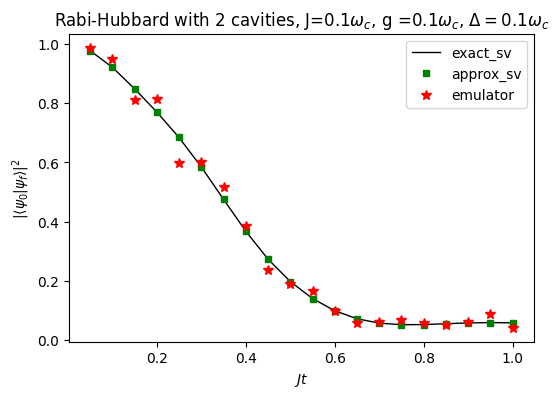

In [36]:
import matplotlib.cm as cm
from matplotlib import pyplot as plt
# import seaborn as sns 
# colors = sns.color_palette('viridis',8)

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)
ax.set_title(f'Rabi-Hubbard with 2 cavities, J={J}$\omega_c$, g ={g}$\omega_c$, $\Delta=${delta:.1f}$\omega_c$')
ax.set_xlabel(f'$Jt$')
ax.set_ylabel(r'$|\langle \psi_0 | \psi_f\rangle|^2$')
x0 = qbackendN_data.time
y0 = exact_sv_data.Sq_overlap
yy = approx_sv_data.Sq_overlap
y1 = qbackendN_data.Sq_overlap

ax.plot(x0, y0, color='k', linewidth=1, label=f'exact_sv')
ax.plot(x0, yy,'s', markersize=4, color='green', label='approx_sv')
ax.plot(x0, y1, '*', markersize=7, color='red', label='emulator')

ax.legend(frameon=True, loc='best')

#### Select unary iteration strategy

In [15]:
from qtnmtts.circuits.select import SelectIndexBox
from qtnmtts.circuits.index.method import IndexDefault, IndexUnaryIteration
from pytket.circuit.display import render_circuit_jupyter
from pytket.passes import DecomposeMultiQubitsCX, RemoveRedundancies


def get_Qbackend_compiled_circuit(circuit, backend=Qbackend):
    # backend = Qbackend #QulacsBackend()#
    backend.empty_cache()

    compiled_circ = backend.get_compiled_circuit(circuit, optimisation_level=2)
    # p_qreg_size = len(compiled_circ.q_registers[1])
    circ2_depth = compiled_circ.depth()
    circ2_2q = compiled_circ.n_2qb_gates()
    return compiled_circ, circ2_depth, circ2_2q

for t in tt[::]:
    n_state_qubits = len(QubitPauliOperator.from_list(Props_red_t[t]).all_qubits)
    index_method = IndexDefault()
    select_box = SelectIndexBox(index_method, QubitPauliOperator.from_list(Props_red_t[t]), n_state_qubits)

    compiled_circ, circ_depth, circ_2q = get_Qbackend_compiled_circuit(select_box.get_circuit(), backend=Qbackend)
    # p_qreg_size = len(compiled_circ.q_registers[1])
    print(f'depth:{circ_depth}, two_q:{circ2_2q}')

depth:929, two_q:522
depth:1267, two_q:522
depth:1280, two_q:522
depth:1271, two_q:522
depth:1270, two_q:522
depth:1268, two_q:522
depth:1274, two_q:522
depth:1262, two_q:522
depth:1268, two_q:522
depth:1278, two_q:522
depth:1267, two_q:522
depth:1273, two_q:522
depth:1271, two_q:522
depth:1260, two_q:522
depth:1273, two_q:522
depth:1267, two_q:522
depth:1273, two_q:522
depth:1264, two_q:522
depth:1279, two_q:522
depth:1270, two_q:522
